In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler

In [2]:
# mpl.matplotlib_fname()

In [3]:
plt.rcParams["axes.facecolor"] = '#0d1117'
plt.rcParams["figure.facecolor"] = '#0d1117'

# plt.rcParams['figure.figsize'] = [7.0, 3.0]
plt.rcParams['figure.dpi'] = 100

# plt.rcParams["axes.spines.bottom.color"]
# plt.rcParams["axes.spines.left"] = '#0d1117'
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

plt.rcParams["axes.edgecolor"] = "#eef7f4"

plt.rcParams["xtick.color"] = '#eef7f4'
plt.rcParams["ytick.color"] = '#eef7f4'


plt.rcParams["axes.labelcolor"] = '#eef7f4'

plt.rcParams["grid.color"] = '#eef7f4'

plt.rcParams["legend.frameon"] = False

plt.rcParams['axes.prop_cycle'] = cycler(color=['g', 'r', 'b', 'y'])

In [4]:
a = 0
b = 1
h = 1e-3

N = int((b-a)/h)

t = np.linspace(a, b, N)

beta = 1
f = np.array([np.exp(beta*t[i]) for i in range(N)])
f_noise = f + np.random.randn(N)

l = -1
K = np.empty((N,N))
for i in range(N):
    for j in range(i+1):
        K[i, j] = np.exp(l*(t[i]-t[j]))

In [5]:
@nb.njit("float64[:](float64[:,:], float64[:], float64, float64[:])", parallel=True)
def solve_quad(k, f, h, x):
    N = len(f)
    x[0]=f[0] # начальное значение
    for i in range(1, N):
        s=np.sum(K[i,1:i]*x[1:i])
        x[i]= (f[i] + h/2*k[i,0]+ h*s)/ (1 - h/2*k[i,i])
    return x

In [6]:
x_sol_quad = solve_quad(K, f, h, np.zeros_like(f))
x_ex = [2*np.exp(t[i])-1 for i in range(N)]

Text(0.5, 1.0, 'квадратуре методы')

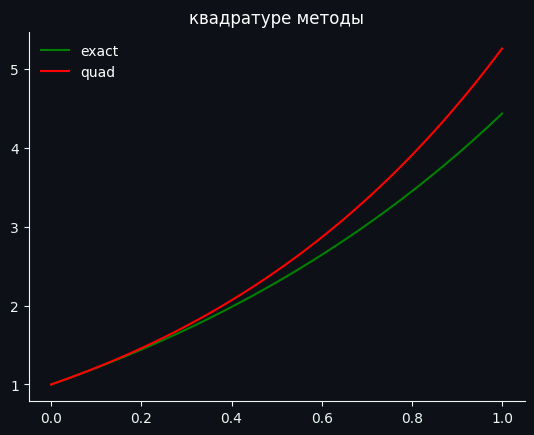

In [24]:
plt.plot(t, x_ex, label="exact")
plt.plot(t, x_sol_quad, label="quad")
plt.legend(labelcolor="w")
plt.title("квадратуре методы", color='w')

In [21]:
def error(exact, solution):
    return np.linalg.norm((exact - solution)/solution)

In [9]:
errors_quad = []

hs = np.logspace(-3, -2, 10)

for h in hs:
    n = int((b-a)/h)
    t = np.linspace(a, b, n)
    x_ex = 2*np.exp(t) - 1
    f = np.exp(beta*t)
    k = np.empty((n,n))
    for i in range(n):
        for j in range(i+1):
            k[i, j] = np.exp(l*(t[i]-t[j]))

    x_sol_quad = solve_quad(k, f, h, np.zeros_like(f))
    errors_quad.append(error(x_ex, x_sol_quad))

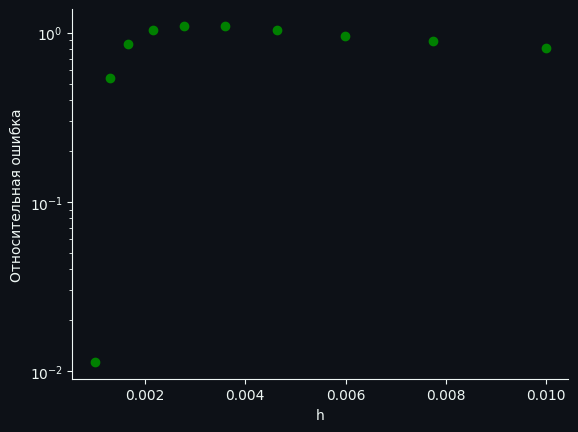

In [10]:
plt.scatter(hs,errors_quad)
plt.ylabel("Относительная ошибка")
plt.xlabel("h")
plt.yscale("log")

In [11]:
from scipy.integrate import cumtrapz, simpson, solve_ivp

In [12]:
a = 0
b = 1
h = 1e-2

N = int((b-a)/h)

t = np.linspace(a, b, N)

beta = 1
f = np.array([np.exp(beta*t[i]) for i in range(N)])

l = -1
K = np.empty((N,N))
for i in range(N):
    for j in range(i+1):
        K[i, j] = np.exp(l*(t[i]-t[j]))

In [13]:
def iter(y, h, x, n, k, f):
    yk = y.copy()
    for i in range(n):
        yk[i] = 0
        for j in range(i):
            yk[i] = yk[i] + 2*k(x[i], x[j])*y[j]
        yk[i] = yk[i] - k(x[i], x[0])*y[0] - k(x[i], x[i])*y[i]
        yk[i] = f(x[i]) + yk[i]*h/2
    return yk


def solve_iter(k, f, x : np.ndarray, h : float, eps: float =1e-1):
    n = len(x)
    y = f(x)
    yk = iter(y, h, x, n, k, f)
    i = 0
    err = np.linalg.norm(y - yk)/np.linalg.norm(y)
    #print(max(y-yk))
    while err > eps:
        #print(error(y, yk))
        y = yk.copy()
        yk = iter(y.copy(), h, x, n, k, f)
        #print(error(y, yk))
        err = error(y, yk)
        i += 1
        if i > 1000: break
    return yk, i

# def solve_iter_n(k, f, x : np.ndarray, h : float, n : int, eps: float =1e-1):
#     n = len(x)
#     y = f(x)
#     yk = iter(y, h, x, n, k, f)
#     i = 0
#     err = np.linalg.norm(y - yk)/np.linalg.norm(y)
#     print(max(y-yk))
#     for _ in range(n):
#         y = yk.copy()
#         yk = iter(y, h, x, n, k, f)
#         i += 1
#     return yk, i

In [14]:
a = 0
b = 1
h = 1e-2

N = int((b-a)/h)

k_func = lambda x, t: np.exp(l*(x-t))
f_func = lambda t: np.exp(beta*t)

x = np.linspace(a, b, N)
x_ex = [2*np.exp(x[i])-1 for i in range(N)]
res, i = solve_iter(k_func, f_func, x, h, eps=1e-10)
#res_, i = solve_iter_n(k_func, f_func, x, h, 10, eps=1e-5)

print(i, error(x_ex, res))

11 0.16771586481430353


Text(0.5, 1.0, 'метод простых итераций')

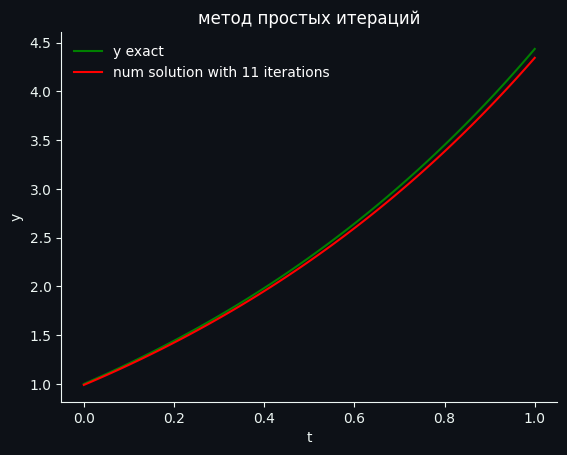

In [15]:
plt.plot(x, x_ex, label='y exact')
plt.plot(x, res, label=f"num solution with {i} iterations")
plt.xlabel("t")
plt.ylabel("y")
plt.legend(labelcolor="w")
plt.title("метод простых итераций", color='w')

In [16]:
f_ = lambda x: x*0 + 1
k_ = lambda x, t: x*0 + t*0 + 1
a_ = 0
b_ = 7
h_ = 0.07
eps_ = 1e-3

y_e = lambda x: np.exp(x)
x_ = np.linspace(a_, b_, int((b_-a_)/h_))
res_, i_ = solve_iter(k_, f_, x_, h_, eps_)

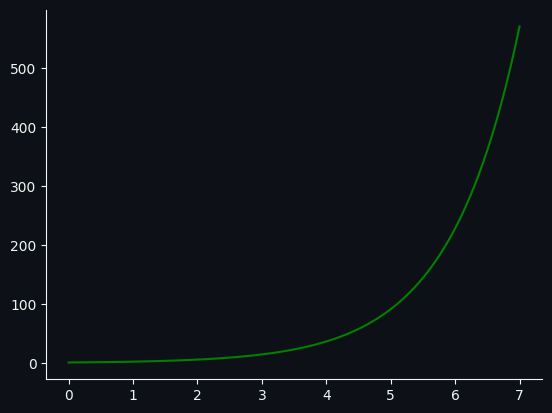

In [17]:
plt.plot(x_, res_)